In [1]:
import os
import csv
import awdb
import json
from tqdm import tqdm

Num_query_all=0         #查询总数
Num_query_success=0     #查询成功总数，不只有a aaaa
Num_query_fail=0        #查询失败总数

Num_query_a_all=0       #查询a记录总数
Num_query_a_success=0   #查询a记录成功数
Num_query_a_fail=0      #查询a记录失败数
Num_query_aaaa_all=0    #查询aaaa总数
Num_query_aaaa_success=0#查询aaaa成功数
Num_query_aaaa_fail=0   #查询aaaa失败数

List_newgTLDs=[]
Num_newgTLDs=0

Dic_state={}
Dic_record_num_all={}       #该种类的记录对应的查询数
Dic_record_num_success={}   #该种类的记录对应的查询成功数

Dic_domain_num_a_all={}     #该域名a查询总数
Dic_domain_num_a_success={} #该域名a查询成功数
Dic_domain_num_a_fail={}    #该域名a查询失败数
Dic_domain_num_aaaa_all={}  #该域名aaaa查询总数
Dic_domain_num_aaaa_success={}#该域名aaaa查询成功数
Dic_domain_num_aaaa_fail={} #该域名aaaa查询失败数

Dic_resolver_num_all={}     #该解析器查询总数
Dic_resolver_num_success={} #该解析器查询成功数
Dic_resolver_num_fail={}    #该解析器查询失败数
Dic_resolver_num_a_all={}   #该解析器查询a记录总数
Dic_resolver_num_a_success={}#该解析器查询a记录成功数
Dic_resolver_num_a_fail={}  #该解析器查询a记录失败数
Dic_resolver_num_aaaa_all={}#该解析器查询aaaa记录总数
Dic_resolver_num_aaaa_success={}#该解析器查询aaaa记录成功数
Dic_resolver_num_aaaa_fail={}#该解析器查询aaaa记录的失败数

Dic_resolver_asnum={}       #该解析器对应的as号
Dic_asnum_asname={}         #该as号对应的as名

Dic_resolver_public_num_all={}#某公共解析器查询总数
Dic_resolver_public_num_success={}
Dic_resolver_public_num_a_all={}
Dic_resolver_public_num_a_success={}
Dic_resolver_public_num_aaaa_all={}
Dic_resolver_public_num_aaaa_success={}


def _init_():
    #读asnum2asname
    global Dic_asnum_asname
    fin=open('./other_data/asnum2asname.txt')
    i=0
    for line in fin:
        list_tp=line.split(None,1)
        Dic_asnum_asname[list_tp[0]]=list_tp[1].strip()
    fin.close()

    #读 new gTLDs
    global List_newgTLDs
    # global Num_newgTLDs
    fin=open('./other_data/new_gtlds_1686227471.csv')
    i=0
    for line in fin:
        tp=line.split(',',1)
        List_newgTLDs.append(tp[0].strip())
    fin.close()

def judge_recursive(Rdic_rr,Rname,Qname):
    if Rname==Qname:
        return 1
    else:
        tp=0
        for Ritem in Rdic_rr:
            if Ritem['type']==5 and Ritem['cname']==Rname:
                tp=judge_recursive(Rdic_rr,Ritem['name'],Qname)
                if tp==1:
                    break
        return tp

def judge_success(Rdic_rr,Qname,Qtype):
    #复杂的判别方法是正着找，我们反着找！
    success=0
    # if Qtype!=1 and Qtype!=28:#不可能出现递归
    #     for Ritem in Rdic_rr:#直接找
    #         if Ritem['name']==Qname and Ritem['type']==Qtype:
    #             success=1
    # else: #是1或28
    for Ritem in Rdic_rr:#对于所有的答案
        if Ritem['type']==Qtype:
            if judge_recursive(Rdic_rr,Ritem['name'],Qname)==1:
                success=1
                break
        if success==1:
            break
    return success

def ip2asnum(str_ip):
    reader=awdb.open_database(r'./other_data/IP_basic_single_WGS84.awdb')
    (record,prefix_len)=reader.get_with_prefix_len(str_ip)
    ans=record.get('asnumber').decode('utf8')
    if ans!='':
        return ans
    else:
        return 'null'

def public_resolver():
    global Dic_resolver_num_all
    global Dic_resolver_num_success
    global Dic_resolver_num_a_all
    global Dic_resolver_num_a_success
    global Dic_resolver_num_aaaa_all
    global Dic_resolver_num_aaaa_success

    #读public_resolver list
    fin=open('./other_data/public_resolver_ip.txt')
    fout=open('./result_data/3_resolver_public.csv','w')
    csv_out=csv.writer(fout)
    csv_out.writerow(['public_resolver','num_all','num_success','rate_success',\
                    'num_a_all','num_a_success','rate_a_success',\
                    'num_aaaa_all','num_aaaa_success','rate_aaaa_success'])
    for line in fin:#对于每个公共解析器
        [public_resolver,ips]=line.split(',',1)
        ips_list=ips.strip().split(',')#是个list
        public_resolver_num_all=0
        public_resolver_num_success=0
        public_resolver_num_a_all=0
        public_resolver_num_a_success=0
        public_resolver_num_aaaa_all=0
        public_resolver_num_aaaa_success=0
        for ip in ips_list:
            if ip in Dic_resolver_num_all:
                public_resolver_num_all+=Dic_resolver_num_all[ip]
            if ip in Dic_resolver_num_success:
                public_resolver_num_success+=Dic_resolver_num_success[ip]
            if ip in Dic_resolver_num_a_all:
                public_resolver_num_a_all+=Dic_resolver_num_a_all[ip]
            if ip in Dic_resolver_num_a_success:
                public_resolver_num_a_success+=Dic_resolver_num_a_success[ip]
            if ip in Dic_resolver_num_aaaa_all:
                public_resolver_num_aaaa_all+=Dic_resolver_num_aaaa_all[ip]
            if ip in Dic_resolver_num_aaaa_success:
                public_resolver_num_aaaa_success+=Dic_resolver_num_aaaa_success[ip]
        if public_resolver_num_all!=0:
            rate_success=str(format(public_resolver_num_success/public_resolver_num_all*100,'.2f'))+'%'
        else:
            rate_success='null'
        if public_resolver_num_a_all!=0:
            rate_a_success=str(format(public_resolver_num_a_success/public_resolver_num_a_all*100,'.2f'))+'%'
        else:
            rate_a_success='null'
        if public_resolver_num_aaaa_all!=0:
            rate_aaaa_success=str(format(public_resolver_num_aaaa_success/public_resolver_num_aaaa_all*100,'.2f'))+'%'
        else:
            rate_aaaa_success='null'
        csv_out.writerow([public_resolver,public_resolver_num_all,public_resolver_num_success,rate_success,\
                        public_resolver_num_a_all,public_resolver_num_a_success,rate_a_success,\
                        public_resolver_num_aaaa_all,public_resolver_num_aaaa_success,rate_aaaa_success])
    fin.close()
    fout.close()

def public_resolver_domains():#挑出不同的解析器各自
    pass

    
def output():#处理结果并输出
    global Dic_record_num_all
    global Dic_record_num_success

    global Num_query_all
    global Num_query_success
    global Num_query_fail
    global Num_query_a_all
    global Num_query_a_success
    global Num_query_a_fail
    global Num_query_aaaa_all
    global Num_query_aaaa_success
    global Num_query_aaaa_fail

    global Dic_domain_num_a_all
    global Dic_domain_num_a_success
    global Dic_domain_num_a_fail
    global Dic_domain_num_aaaa_all
    global Dic_domain_num_aaaa_success
    global Dic_domain_num_aaaa_fail

    dir_out='./result_data'
    file_name_type='1_type.csv'#存放不同类型查询数量、成功数量、失败数量、成功率
    file_name_domain_a='2_domain_a.csv'#存放域名与a记录相关
    file_name_domain_aaaa='2_domain_aaaa.csv'#存放域名与aaaa记录相关
    file_out_path_type=os.path.join(dir_out,file_name_type)
    file_out_path_domain_a=os.path.join(dir_out,file_name_domain_a)
    file_out_path_domain_aaaa=os.path.join(dir_out,file_name_domain_aaaa)

    #不同记录类型输出
    Record_num_all_sorted=dict(sorted(Dic_record_num_all.items(),key=lambda x:x[1],reverse=True))
    file_out_type=open(file_out_path_type,'w')
    csv_out=csv.writer(file_out_type)
    csv_out.writerow(['type','num_all','rate_all','num_success','rate_success'])
    for key,val in Record_num_all_sorted.items():
        csv_out.writerow([key,val,str(format(val/Num_query_all*100,'.2f'))+'%',\
                Dic_record_num_success[key],str(format(Dic_record_num_success[key]/val*100,'.2f'))+'%'])

    #不同域名a记录按失败次数高低输出
    for key in Dic_domain_num_a_all:#a记录
        Dic_domain_num_a_fail[key]=Dic_domain_num_a_all[key]-Dic_domain_num_a_success[key]
    Dic_domain_num_a_fail_sorted=dict(sorted(Dic_domain_num_a_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_a=open(file_out_path_domain_a,'w')
    csv_out=csv.writer(file_out_domain_a)
    #domain域名，num_a_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_a_all是这个域名所有a记录查询的数量，num_a_success是这个域名所有a记录查询的成功数，rate_a_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_a_fail','rate_all','num_a_all','num_a_success','rate_a_fail'])
    for key,val in Dic_domain_num_a_fail_sorted.items():
        csv_out.writerow([key,val,str(format(val/Num_query_a_fail*100,'.2f'))+'%',\
                        Dic_domain_num_a_all[key],Dic_domain_num_a_success[key],\
                        str(format(val/Dic_domain_num_a_all[key]*100,'.2f'))+'%'])

    #不同域名aaaa记录按失败次数高低输出
    for key in Dic_domain_num_aaaa_all:#aaaa记录
        Dic_domain_num_aaaa_fail[key]=Dic_domain_num_aaaa_all[key]-Dic_domain_num_aaaa_success[key]
    Dic_domain_num_aaaa_fail_sorted=dict(sorted(Dic_domain_num_aaaa_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_aaaa=open(file_out_path_domain_aaaa,'w')
    csv_out=csv.writer(file_out_domain_aaaa)
    #domain域名，num_aaaa_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_aaaa_all是这个域名所有a记录查询的数量，num_aaaa_success是这个域名所有a记录查询的成功数，rate_aaaa_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_aaaa_fail','rate_all','num_aaaa_all','num_aaaa_success','rate_aaaa_fail'])
    for key,val in Dic_domain_num_aaaa_fail_sorted.items():
        csv_out.writerow([key,val,str(format(val/Num_query_aaaa_fail*100,'.2f'))+'%',\
                        Dic_domain_num_aaaa_all[key],Dic_domain_num_aaaa_success[key],\
                        str(format(val/Dic_domain_num_aaaa_all[key]*100,'.2f'))+'%'])
    
    #单独写个去低频的
    #不同域名a记录按失败次数高低输出
    Num_query_a_fail_frequent=0
    for key in Dic_domain_num_a_all:
        if Dic_domain_num_a_all[key]>=100:
            Num_query_a_fail_frequent+=Dic_domain_num_a_fail[key]
    for key in Dic_domain_num_a_all:#a记录
        Dic_domain_num_a_fail[key]=Dic_domain_num_a_all[key]-Dic_domain_num_a_success[key]
    Dic_domain_num_a_fail_sorted=dict(sorted(Dic_domain_num_a_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_a=open('./result_data/2_domain_a_frequent.csv','w')
    csv_out=csv.writer(file_out_domain_a)
    #domain域名，num_a_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_a_all是这个域名所有a记录查询的数量，num_a_success是这个域名所有a记录查询的成功数，rate_a_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_a_fail','rate_all','num_a_all','num_a_success','rate_a_fail'])
    for key,val in Dic_domain_num_a_fail_sorted.items():
        if Dic_domain_num_a_all[key]>=100:
            csv_out.writerow([key,val,str(format(val/Num_query_a_fail_frequent*100,'.2f'))+'%',\
                            Dic_domain_num_a_all[key],Dic_domain_num_a_success[key],\
                            str(format(val/Dic_domain_num_a_all[key]*100,'.2f'))+'%'])
    #不同域名aaaa记录按失败次数高低输出
    Num_query_aaaa_fail_frequent=0
    for key in Dic_domain_num_aaaa_all:
        if Dic_domain_num_aaaa_all[key]>=100:
            Num_query_aaaa_fail_frequent+=Dic_domain_num_aaaa_fail[key]
    for key in Dic_domain_num_aaaa_all:#aaaa记录
        Dic_domain_num_aaaa_fail[key]=Dic_domain_num_aaaa_all[key]-Dic_domain_num_aaaa_success[key]
    Dic_domain_num_aaaa_fail_sorted=dict(sorted(Dic_domain_num_aaaa_fail.items(),key=lambda x:x[1],reverse=True))
    file_out_domain_aaaa=open('./result_data/2_domain_aaaa_frequent.csv','w')
    csv_out=csv.writer(file_out_domain_aaaa)
    #domain域名，num_aaaa_fail是这个域名a记录失败次数，rate_all是这个域名失败次数占所有a失败的次数
    #num_aaaa_all是这个域名所有a记录查询的数量，num_aaaa_success是这个域名所有a记录查询的成功数，rate_aaaa_success是这个域名查询的成功率
    csv_out.writerow(['domain','num_aaaa_fail','rate_all','num_aaaa_all','num_aaaa_success','rate_aaaa_fail'])
    for key,val in Dic_domain_num_aaaa_fail_sorted.items():
        if Dic_domain_num_aaaa_all[key]>=100:
            csv_out.writerow([key,val,str(format(val/Num_query_aaaa_fail_frequent*100,'.2f'))+'%',\
                            Dic_domain_num_aaaa_all[key],Dic_domain_num_aaaa_success[key],\
                            str(format(val/Dic_domain_num_aaaa_all[key]*100,'.2f'))+'%'])
def output2():
    global Dic_record_num_all
    global Dic_record_num_success

    global Num_query_all
    global Num_query_success
    global Num_query_fail
    global Num_query_a_all
    global Num_query_a_success
    global Num_query_a_fail
    global Num_query_aaaa_all
    global Num_query_aaaa_success
    global Num_query_aaaa_fail

    global Dic_resolver_num_all
    global Dic_resolver_num_success
    global Dic_resolver_num_fail
    global Dic_resolver_num_a_all
    global Dic_resolver_num_a_success
    global Dic_resolver_num_a_fail
    global Dic_resolver_num_aaaa_all
    global Dic_resolver_num_aaaa_success
    global Dic_resolver_num_aaaa_fail

    dir_out='./result_data'
    file_name_resolver_all='3_resolver_all.csv'
    file_name_resolver_a='3_resolver_a.csv'
    file_name_resolver_aaaa='3_resolver_aaaa.csv'

    file_out_path_resolver_all=os.path.join(dir_out,file_name_resolver_all)
    file_out_path_resolver_a=os.path.join(dir_out,file_name_resolver_a)
    file_out_path_resolver_aaaa=os.path.join(dir_out,file_name_resolver_aaaa)

    #resolver所有查询输出
    Dic_resolver_num_all_sorted=dict(sorted(Dic_resolver_num_all.items(),key=lambda x:x[1],reverse=True))
    file_out_resolver_all=open(file_out_path_resolver_all,'w')
    csv_out=csv.writer(file_out_resolver_all)
    csv_out.writerow(['resolver_ip','num_all','rate_all','num_success','rate_success','asnum','asname','country'])
    for key,val in Dic_resolver_num_all_sorted.items():
        asnum=Dic_resolver_asnum[key]
        asname=''
        country=''
        if asnum=='null':
            asname='null'
            country='null'
        else:
            [asname,country]=Dic_asnum_asname['AS'+str(Dic_resolver_asnum[key])].rsplit(', ',1)
        csv_out.writerow([key,val,str(format(val/Num_query_all*100,'.2f'))+'%',\
                    Dic_resolver_num_success[key],\
                    str(format(Dic_resolver_num_success[key]/val*100,'.2f'))+'%',\
                    asnum,asname,country])
        
    #resolver的a记录查询输出
    Dic_resolver_num_a_all_sorted=dict(sorted(Dic_resolver_num_a_all.items(),key=lambda x:x[1],reverse=True))
    file_out_resolver_a=open(file_out_path_resolver_a,'w')
    csv_out=csv.writer(file_out_resolver_a)
    csv_out.writerow(['resolver_ip','num_a_all','rate_a_all','num_a_success','rate_a_success','asnum','asname','country'])
    for key,val in Dic_resolver_num_a_all_sorted.items():
        asnum=Dic_resolver_asnum[key]
        asname=''
        country=''
        if asnum=='null':
            asname='null'
            country='null'
        else:
            [asname,country]=Dic_asnum_asname['AS'+str(Dic_resolver_asnum[key])].rsplit(', ',1)
        csv_out.writerow([key,val,str(format(val/Num_query_a_all*100,'.2f'))+'%',\
                    Dic_resolver_num_a_success[key],\
                    str(format(Dic_resolver_num_a_success[key]/val*100,'.2f'))+'%',\
                    asnum,asname,country])
    #resolver的aaaa记录查询输出
    Dic_resolver_num_aaaa_all_sorted=dict(sorted(Dic_resolver_num_aaaa_all.items(),key=lambda x:x[1],reverse=True))
    file_out_resolver_aaaa=open(file_out_path_resolver_aaaa,'w')
    csv_out=csv.writer(file_out_resolver_aaaa)
    csv_out.writerow(['resolver_ip','num_aaaa_all','rate_aaaa_all','num_aaaa_success','rate_aaaa_success','asnum','asname','country'])
    for key,val in Dic_resolver_num_aaaa_all_sorted.items():
        asnum=Dic_resolver_asnum[key]
        asname=''
        country=''
        if asnum=='null':
            asname='null'
            country='null'
        else:
            [asname,country]=Dic_asnum_asname['AS'+str(Dic_resolver_asnum[key])].rsplit(', ',1)
        csv_out.writerow([key,val,str(format(val/Num_query_aaaa_all*100,'.2f'))+'%',\
                    Dic_resolver_num_aaaa_success[key],\
                    str(format(Dic_resolver_num_aaaa_success[key]/val*100,'.2f'))+'%',\
                    asnum,asname,country])
    #搞一个求公共DNS厂商的
    public_resolver()
def output3():
    pass
def process():
    global List_newgTLDs
    global Num_newgTLDs

    global Dic_state
    global Dic_record_num_all
    global Dic_record_num_success

    global Num_query_all
    global Num_query_success
    global Num_query_fail
    global Num_query_a_all
    global Num_query_a_success
    global Num_query_a_fail
    global Num_query_aaaa_all
    global Num_query_aaaa_success
    global Num_query_aaaa_fail

    global Dic_domain_num_a_all
    global Dic_domain_num_a_success
    global Dic_domain_num_a_fail
    global Dic_domain_num_aaaa_all
    global Dic_domain_num_aaaa_success
    global Dic_domain_num_aaaa_fail

    global Dic_resolver_num_all
    global Dic_resolver_num_success
    global Dic_resolver_num_fail
    global Dic_resolver_num_a_all
    global Dic_resolver_num_a_success
    global Dic_resolver_num_a_fail
    global Dic_resolver_num_aaaa_all
    global Dic_resolver_num_aaaa_success
    global Dic_resolver_num_aaaa_fail

    dir_in='./source_data'
    file_names=os.listdir(dir_in)
    for file_name in tqdm(file_names):#对于每个源文件
        if file_name=='.DS_Store':
            continue
        #输入文件的路径
        file_in_path=os.path.join(dir_in,file_name)
        #输入的文件对象
        file_in=open(file_in_path,'r',encoding='utf-8-sig')
        csv_in=csv.reader(file_in)
        i=0
        for line in csv_in:#对于每一行数据
            #对于DNS响应才做处理
            i+=1
            if i>1000000:
                break
            QorR=int(line[113]) #0是query 1是response
            if QorR==1:#是R 即响应
                if line[119] in Dic_state:
                    Dic_state[line[119]]+=1
                else:
                    Dic_state[line[119]]=0
                if line[119]!='0':#nxdomain
                    continue
                Qname=line[124]
                Qtype=int(line[125])#该响应的查询种类 （数字类型
                #判断new gTLD
                TLD=Qname.rsplit('.',1)[-1]
                if TLD in List_newgTLDs:
                    Num_newgTLDs+=1
                # else:
                #     continue
                #但凡有查询就记录下来
                Num_query_all+=1
                #对不同查询类型的记录
                if Qtype in Dic_record_num_all:
                    Dic_record_num_all[Qtype]+=1
                else:
                    Dic_record_num_all[Qtype]=1
                    #这里注意！！！success同时统计
                    Dic_record_num_success[Qtype]=0
                #对不同查询域名的记录
                if Qtype==1:
                    Num_query_a_all+=1
                    if Qname in Dic_domain_num_a_all:
                        Dic_domain_num_a_all[Qname]+=1
                    else:
                        Dic_domain_num_a_all[Qname]=1
                        Dic_domain_num_a_success[Qname]=0
                elif Qtype==28:
                    Num_query_aaaa_all+=1
                    if Qname in Dic_domain_num_aaaa_all:
                        Dic_domain_num_aaaa_all[Qname]+=1
                    else:
                        Dic_domain_num_aaaa_all[Qname]=1
                        Dic_domain_num_aaaa_success[Qname]=0
                #对不同解析器的记录
                resolver=line[33]#用ip标识
                if resolver in Dic_resolver_num_all:
                    Dic_resolver_num_all[resolver]+=1
                else:
                    Dic_resolver_num_all[resolver]=1
                    Dic_resolver_num_success[resolver]=0
                    #ip2asnum
                    Dic_resolver_asnum[resolver]=ip2asnum(resolver)

                if Qtype==1:
                    if resolver in Dic_resolver_num_a_all:
                        Dic_resolver_num_a_all[resolver]+=1
                    else:
                        Dic_resolver_num_a_all[resolver]=1
                        Dic_resolver_num_a_success[resolver]=0
                elif Qtype==28:
                    if resolver in Dic_resolver_num_aaaa_all:
                        Dic_resolver_num_aaaa_all[resolver]+=1
                    else:
                        Dic_resolver_num_aaaa_all[resolver]=1
                        Dic_resolver_num_aaaa_success[resolver]=0
                
                #下面再判断是否成功
                Rdic=json.loads(line[129])
                success=judge_success(Rdic['rr'],Qname,Qtype)
                if success==1:
                    Num_query_success+=1
                    #记录类型
                    Dic_record_num_success[Qtype]+=1
                    #域名 解析器
                    Dic_resolver_num_success[resolver]+=1
                    if Qtype==1:
                        Num_query_a_success+=1
                        Dic_domain_num_a_success[Qname]+=1
                        Dic_resolver_num_a_success[resolver]+=1
                    elif Qtype==28:
                        Num_query_aaaa_success+=1
                        Dic_domain_num_aaaa_success[Qname]+=1
                        Dic_resolver_num_aaaa_success[resolver]+=1
                    # print('code '+line[119])
                    # print(Qname+' '+str(Qtype))
                    # print(Rdic)
                # else:
                #     print('code '+line[119])
                #     print(Qname+' '+str(Qtype))
                #     print(Rdic)
        break
    print(Dic_state)
    print(Num_newgTLDs)
    Num_query_a_fail=Num_query_a_all-Num_query_a_success
    Num_query_aaaa_fail=Num_query_aaaa_all-Num_query_aaaa_success

if __name__=='__main__':
    _init_()
    process()
    # output()
    # output2()

  0%|          | 0/36 [00:13<?, ?it/s]

{'0': 497318, '3': 46512, '2': 6029, '4': 39, '5': 73, '1': 2}
13635


In [4]:

a='www.baidu.com'
s=a.rsplit('.',1)[-1]
s

'com'

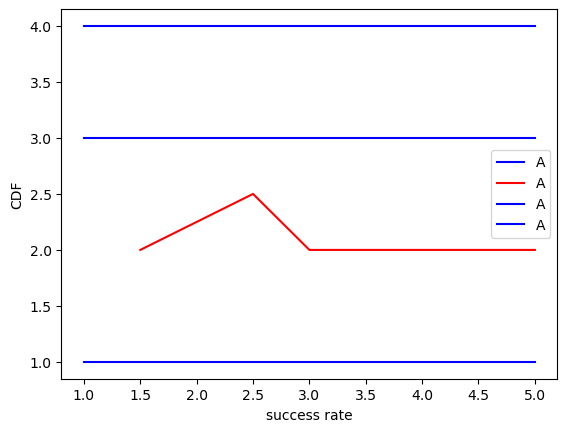

In [18]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4,5],[1,1,1,1,1],'-',color = 'b',label="A")
plt.plot([1.5,2.5,3,4,5],[2,2.5,2,2,2],'-',color = 'r',label="A")
plt.plot([1,2,3,4,5],[3,3,3,3,3],'-',color = 'b',label="A")
plt.plot([1,2,3,4,5],[4,4,4,4,4],'-',color = 'b',label="A")
plt.xlabel("success rate")#横坐标名字
plt.ylabel("CDF")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

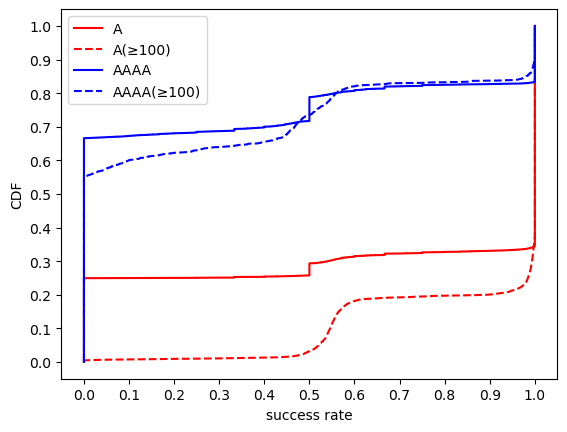

In [2]:
import matplotlib.pyplot as plt
import csv
#横坐标是成功率
x_a=[]
y_a=[]
x_a_frequent=[]
y_a_frequent=[]
x_aaaa=[]
y_aaaa=[]
x_aaaa_frequent=[]
y_aaaa_frequent=[]

standard=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# standard=[]

fin=open('result_data0/CDF/2_domain_a_CDF.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_a.append(float(line[6]))
    y_a.append(float(line[7]))
fin.close()

fin_a_frequent=open('result_data0/CDF/2_domain_a_frequent_CDF.csv')
csv_in_a_frequent=csv.reader(fin_a_frequent)
next(csv_in_a_frequent)
for line in csv_in_a_frequent:
    x_a_frequent.append(float(line[6]))
    y_a_frequent.append(float(line[7]))
fin_a_frequent.close()

fin=open('result_data0/CDF/2_domain_aaaa_CDF.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_aaaa.append(float(line[6]))
    y_aaaa.append(float(line[7]))
fin.close()

fin_aaaa_frequent=open('result_data0/CDF/2_domain_aaaa_frequent_CDF.csv')
csv_in_aaaa_frequent=csv.reader(fin_aaaa_frequent)
next(csv_in_aaaa_frequent)
for line in csv_in_aaaa_frequent:
    x_aaaa_frequent.append(float(line[6]))
    y_aaaa_frequent.append(float(line[7]))
fin_aaaa_frequent.close()

plt.figure()
plt.plot(x_a,y_a,'-',color = 'r',label="A")
plt.plot(x_a_frequent,y_a_frequent,'--',color = 'r',label="A(≥100)")
plt.plot(x_aaaa,y_aaaa,'-',color = 'b',label="AAAA")
plt.plot(x_aaaa_frequent,y_aaaa_frequent,'--',color = 'b',label="AAAA(≥100)")

plt.xticks(standard)
plt.yticks(standard)
plt.xlabel("success rate")#横坐标名字
plt.ylabel("CDF")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

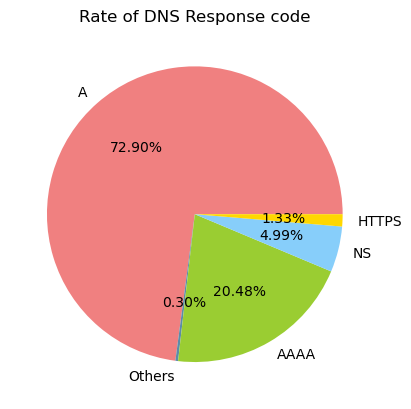

In [13]:
import matplotlib.pyplot as plt
y=[12144300,49242,3411805,831295,222079]
plt.pie(y,
        labels=['A','Others','AAAA','NS','HTTPS'], # 设置饼图标签
        colors=["lightcoral", "#5d8ca8", "yellowgreen", "lightskyblue", "gold"], # 设置饼图颜色
        autopct='%.2f%%'
       )
plt.title("Rate of DNS Response code") # 设置标题
plt.show()

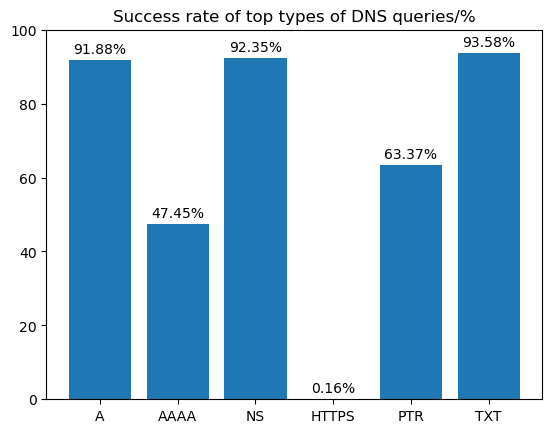

In [1]:
import matplotlib.pyplot as plt

x = ["A", "AAAA", "NS", "HTTPS",'PTR','TXT']
y = [91.88, 47.45, 92.35, 0.16,63.37,93.58]

plt.bar(x,y)
for a,b in zip(x,y):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')
plt.yticks([0,20,40,60,80,100])
plt.title('Success rate of top types of DNS queries/%')
plt.show()

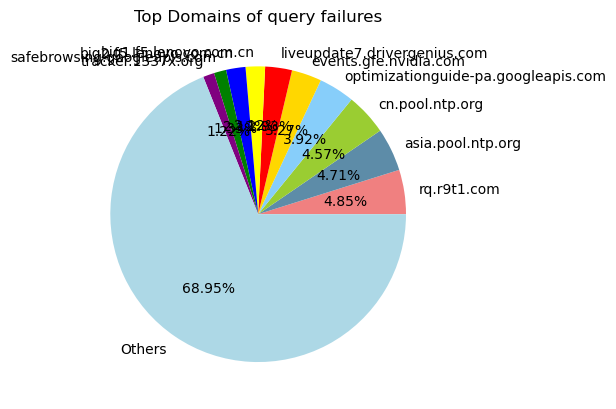

In [2]:
import matplotlib.pyplot as plt
y=[42513,41282,40033,34376,28718,25677,18633,18622,11706,10726,604612]
plt.pie(y,
        labels=['rq.r9t1.com','asia.pool.ntp.org','cn.pool.ntp.org',\
                'optimizationguide-pa.googleapis.com','events.gfe.nvidia.com',\
                'liveupdate7.drivergenius.com','big1.f5.lenovo.com.cn',\
                'big2.f5.lenovo.com.cn','safebrowsing.googleapis.com',\
                'tracker.1337x.org','Others'], # 设置饼图标签
        colors=["lightcoral", "#5d8ca8", "yellowgreen", "lightskyblue", "gold",\
                'red','yellow','blue','green','purple','lightblue'], # 设置饼图颜色
        autopct='%.2f%%'
       )
plt.title("Top Domains of query failures") # 设置标题
plt.show()

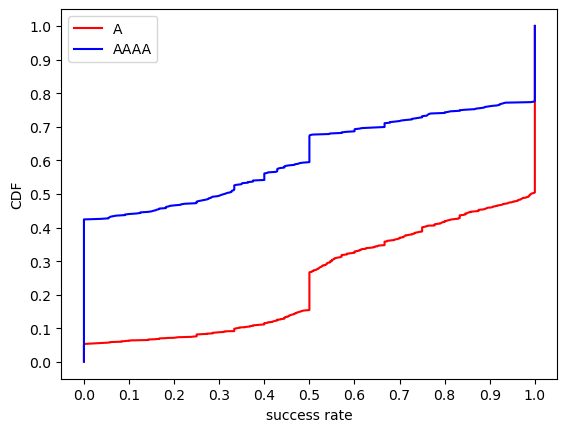

In [37]:
import matplotlib.pyplot as plt
import csv
#横坐标是成功率
x_a=[]
y_a=[]
x_aaaa=[]
y_aaaa=[]

standard=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# standard=[]

fin=open('result_data0/paints/3_resolver_a_CDF.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_a.append(float(line[4]))
    y_a.append(float(line[8]))
fin.close()

fin=open('result_data0/paints/3_resolver_aaaa_CDF.csv')
csv_in=csv.reader(fin)
next(csv_in)
for line in csv_in:
    x_aaaa.append(float(line[4]))
    y_aaaa.append(float(line[8]))
fin.close()

plt.figure()
plt.plot(x_a,y_a,'-',color = 'r',label="A")
plt.plot(x_aaaa,y_aaaa,'-',color = 'b',label="AAAA")

plt.xticks(standard)
plt.yticks(standard)
plt.xlabel("success rate")#横坐标名字
plt.ylabel("CDF")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

[0]


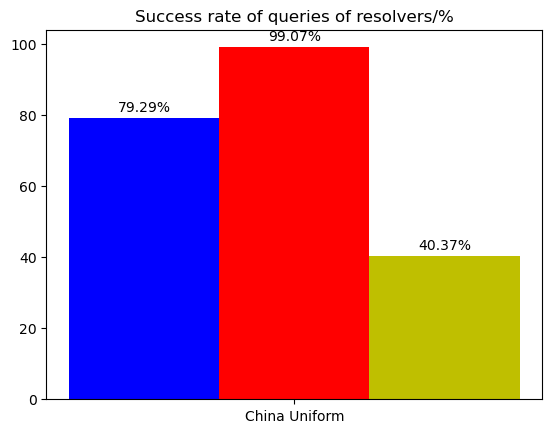

In [3]:
import matplotlib.pyplot as plt

name_list= ["114DNS", "AliDNS", "360DNS", "DNSPOD",'GoogleDNS','OpenDNS','cloudflare']
x=[0,3,6,9,12,15,18]
print(x)
y0 = [73.58,85.29,68.57,73.22,88.19,91.91,68.57]
y1 = [87.18,94.92,84.82,90.34,96.24,98.88,90.71]
y2 = [32.16,72.59,39.19,27.66,37.33,43.32,15.91]
total_width=2
width=total_width/3

plt.bar(x,y0,width=width,label='all',fc='b')
for a,b in zip(x,y0):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')

for i in range(len(x)):
    x[i]=x[i]+width
plt.bar(x,y1,width=width,label='a',fc='r',tick_label=name_list)
for a,b in zip(x,y1):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')

for i in range(len(x)):
    x[i]=x[i]+width
plt.bar(x,y2,width=width,label='aaaa',fc='y')
for a,b in zip(x,y2):
    plt.text(a,b+1,'%.2f'%b+'%',ha='center',va='bottom')
plt.yticks([0,20,40,60,80,100])
plt.title('Success rate of queries of resolvers/%')
plt.show()

findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSoft YaHei' not found.
findfont: Font family 'MicroSof

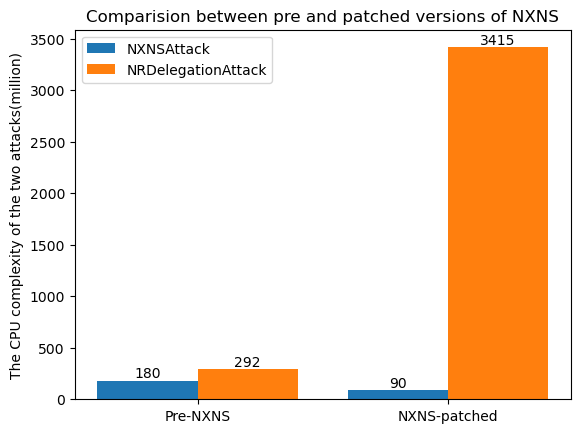

In [22]:
# import matplotlib.pyplot as plt

# name_list= ["Pre-NXNS", "NXNS-patched"]
# x=[0,3]
# print(x)
# y0 = [292,3415]
# y1 = [180,90]
# total_width=2
# width=total_width/2

# plt.bar(x,y0,width=width,label='all',fc='b')
# for a,b in zip(x,y0):
#     plt.text(a,b+1,'%.0f'%b,ha='center',va='bottom')

# for i in range(len(x)):
#     x[i]=x[i]+width
# plt.bar(x,y1,width=width,label='a',fc='r',tick_label=name_list)
# for a,b in zip(x,y1):
#     plt.text(a,b+1,'%.0f'%b,ha='center',va='bottom')

# # plt.yticks([0,20,40,60,80,100])
# plt.title('Comparision between pre and patched versions of NXNS/million')
# plt.show()

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def drawHistogram():
    matplotlib.rc("font", family='MicroSoft YaHei')
    list1 = np.array([180,90])   # 柱状图第一组数据
    list2 = np.array([292,3415])   # 柱状图第二组数据
    length = len(list1)
    x = np.arange(length)   # 横坐标范围
    listDate = ["Pre-NXNS", "NXNS-patched"]

    plt.figure()
    total_width, n = 0.8, 2   # 柱状图总宽度，有几组数据
    width = total_width / n   # 单个柱状图的宽度
    x1 = x - width / 2   # 第一组数据柱状图横坐标起始位置
    x2 = x1 + width   # 第二组数据柱状图横坐标起始位置

    plt.title("Comparision between pre and patched versions of NXNS")   # 柱状图标题
    # plt.xlabel("星期")   # 横坐标label 此处可以不添加
    plt.ylabel("The CPU complexity of the two attacks(million)")   # 纵坐标label
    plt.bar(x1, list1, width=width, label="NXNSAttack")
    for a,b in zip(x1,list1):
        plt.text(a,b+1,'%.0f'%b,ha='center',va='bottom')
    plt.bar(x2, list2, width=width, label="NRDelegationAttack")
    for a,b in zip(x2,list2):
        plt.text(a,b+1,'%.0f'%b,ha='center',va='bottom')
    plt.xticks(x, listDate)   # 用星期几替换横坐标x的值
    plt.legend()   # 给出图例
    plt.show()

if __name__ == '__main__':
    drawHistogram()


In [4]:
#输出所有非0非3的
import csv
import os
from tqdm import tqdm
dir_in='./source_data'
file_names=os.listdir(dir_in)
dic={}
for file_name in tqdm(file_names):#对于每个源文件
    if file_name=='.DS_Store':
        continue
    #输入文件的路径
    file_in_path=os.path.join(dir_in,file_name)
    #输入的文件对象
    file_in=open(file_in_path,'r',encoding='utf-8-sig')
    csv_in=csv.reader(file_in)
    i=0
    for line in csv_in:#对于每一行数据
        #对于DNS响应才做处理
        i+=1
        # if i>1000000:
        #     break
        if line[119] in dic:
            dic[line[119]]+=1
        else:
            dic[line[119]]=0
    break
print(dic)

  0%|          | 0/36 [00:07<?, ?it/s]

{'0': 947339, '3': 46512, '2': 6029, '4': 39, '5': 73, '1': 2}
